In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import Dataset,TensorDataset
import models as clModel,dutils
import cladec
import numpy as np,os
import torch.cuda.amp as tca
import matplotlib
from matplotlib import pyplot as plt


In [3]:
def showPics(pics, mtit="", tits =None,nrows = 16,ncols=12,fname="expPics"):
    picPerFig = nrows * ncols
    for i in range(max(1,pics.shape[0] // picPerFig)):
        fig = plt.figure(figsize=(20,30))
        fig.suptitle(mtit, fontsize=8)
        for j in range(picPerFig):
            if i * picPerFig + j == pics.shape[0]: break
            ax1 = plt.subplot(nrows, (picPerFig - 1) // nrows + 1, j + 1)
            if not tits is None and i*picPerFig + j<len(tits):
               tit=ax1.set_title(str(tits[i*picPerFig + j]), fontsize=16)
               plt.setp(tit, color='black')
            cpic=pics[i * picPerFig + j].squeeze()
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.axis('off')
            cpic = 1-(cpic-np.min(cpic))/(np.max(cpic)-np.min(cpic)+1e-10)
            plt.imshow(cpic.astype(np.float32),cmap='Greys')
        plt.subplots_adjust(wspace=0, hspace=0)
        #plt.savefig(fname+str(i)+ ".png")
        plt.show()
        if i * picPerFig + j >= pics.shape[0] - 1: break
        plt.savefig("layer_5.png")

def getActs(ds,actModel,cfg):
        acts=[]
        X,y=[],[]
        for i, data in enumerate(ds):
            with tca.autocast():
                dsx, dsy = data[0].cuda(), data[1].cuda()
                X.append(data[0])
                y.append(data[1])
                #classifier(dsx)
                acts.append(actModel(dsx).detach().cpu())
        X=torch.cat(X,dim=0)
        y=torch.cat(y, dim=0)
        conacts=torch.cat(acts,dim=0)
        dsact=TensorDataset(X,y,conacts)
        return torch.utils.data.DataLoader(dsact, batch_size=cfg["batchSize"], shuffle=True, num_workers=4)


In [5]:
dummy=False
#dummy = True
#cfg={ 'ds': ('Fash', 10),  #Dataset either  ('Ci100', 100) or ('Ci10', 10)
#      'batchSize': 128, 'opt': ('S', 1 if dummy else 64, 0.1, 0.0001), #optimizer settings
#      'layInd':-1, #Layer to explain (from last layer back, ie. -1 is last (linear), -2 is last conv, -3 second last conv)
#      'alpha': 0.001, #tradeoff parameter reconstruction vs. classification loss
#      'ntrain': 500 if dummy else 60000}
cfg={ 'ds': ('TinyImgNet', 10),  #Dataset either  ('Ci100', 100) or ('Ci10', 10)
    'batchSize': 128, 'opt': ('S', 1 if dummy else 64, 0.1, 0.0001), #optimizer settings
    'layInd':-1, #Layer to explain (from last layer back, ie. -1 is last (linear), -2 is last conv, -3 second last conv)
    'alpha': 0.001, #tradeoff parameter reconstruction vs. classification loss
    'ntrain': 500 if dummy else 60000}
print("Executing config",cfg)
cfg["num_classes"]=cfg["ds"][1]
#Get Data
print("Get dataset")
train_dataset, val_dataset=dutils.getFullDS(cfg)


Executing config {'ds': ('TinyImgNet', 10), 'batchSize': 128, 'opt': ('S', 64, 0.1, 0.0001), 'layInd': -1, 'alpha': 0.001, 'ntrain': 60000}
Get dataset


ValueError: too many values to unpack (expected 2)

In [6]:
dummy=False
#dummy = True
#cfg={ 'ds': ('Fash', 10),  #Dataset either  ('Ci100', 100) or ('Ci10', 10)
#      'batchSize': 128, 'opt': ('S', 1 if dummy else 64, 0.1, 0.0001), #optimizer settings
#      'layInd':-1, #Layer to explain (from last layer back, ie. -1 is last (linear), -2 is last conv, -3 second last conv)
#      'alpha': 0.001, #tradeoff parameter reconstruction vs. classification loss
#      'ntrain': 500 if dummy else 60000}
cfg={ 'ds': ('MNIST', 10),  #Dataset either  ('Ci100', 100) or ('Ci10', 10)
    'batchSize': 128, 'opt': ('S', 1 if dummy else 64, 0.1, 0.0001), #optimizer settings
    'layInd':-1, #Layer to explain (from last layer back, ie. -1 is last (linear), -2 is last conv, -3 second last conv)
    'alpha': 0.001, #tradeoff parameter reconstruction vs. classification loss
    'ntrain': 500 if dummy else 60000}
print("Executing config",cfg)
cfg["num_classes"]=cfg["ds"][1]
#Get Data
print("Get dataset")
train_dataset, val_dataset,norm=dutils.getFullDS(cfg)


Executing config {'ds': ('MNIST', 10), 'batchSize': 128, 'opt': ('S', 64, 0.1, 0.0001), 'layInd': -1, 'alpha': 0.001, 'ntrain': 60000}
Get dataset
Data stats <class 'torchvision.datasets.mnist.MNIST'> (60000, 1, 32, 32) [0.13306338] [0.310658] 1.0 0.0  Data should be normalized
Data stats <class 'torchvision.datasets.mnist.MNIST'> (10000, 1, 32, 32) [0.13479982] [0.31289634] 1.0 0.0  Data should be normalized


In [7]:
%%time
# Train and save non-reflective Model
classifier, lcfg = clModel.getclassifier(cfg,  train_dataset, val_dataset, norm=norm)
print("Classifier Accuracy",lcfg)


Train Classifier to explain
0 [0.07767 0.9809  0.98323]
4 [0.03143 0.9924  0.99677]
8 [0.01247 0.9878  0.99458]
12 [0.00875 0.9909  0.99792]
20 [0.00759 0.9918  0.99853]
40 [5.1000e-04 9.9340e-01 9.9998e-01]
60 [4.500e-04 9.941e-01 1.000e+00]
Classifier Accuracy {'testAcc': 0.9936, 'trainAcc': 1.0}
CPU times: user 6min 10s, sys: 32.2 s, total: 6min 42s
Wall time: 6min 48s


In [6]:
batch, label = next(iter(train_dataset))

In [139]:
b = next(iter(teds))
c = next(iter(val_acts))

In [146]:
b[2].shape

torch.Size([128, 128, 4, 4])

In [151]:
cladecNet(actModel(c[0].float().cuda()))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [32, 1, 3, 3], but got 2-dimensional input of size [128, 512] instead

In [5]:
def getReconstrDS(acts_ds,refAE,cladecNet,cfg):
    X_cladec,X_refae,y=[],[],[]
    cladec_loss, refae_loss = 0, 0
    for i, data in enumerate(acts_ds):
        #if i > 2: break
        with tca.autocast():
            with torch.no_grad():
                dsx, dsy,dsact = data[0].cuda(), data[1], data[2].cuda()
                outCla = cladecNet(dsact).detach().cpu().float()
                outAE = refAE(dsx).detach().cpu().float()
                dsx = dsx.detach().squeeze().cpu().float()
                cladec_loss += (outCla - dsx).pow(2).mean()
                refae_loss += (outAE - dsx).pow(2).mean()
                X_cladec.append(outCla)
                X_refae.append(outAE)
                y.append(dsy)
    
    
    refae_loss = refae_loss/i
    cladec_loss = cladec_loss/i
    X_cladec = torch.cat(X_cladec, dim = 0)
    X_refae = torch.cat(X_refae, dim = 0)
    y = torch.cat(y, dim=0)
    cladec_ds = TensorDataset(X_cladec, y)
    refae_ds = TensorDataset(X_refae, y)
    
    cladec_loader = torch.utils.data.DataLoader(cladec_ds, batch_size=cfg["batchSize"], shuffle=True, num_workers=4)
    refae_loader = torch.utils.data.DataLoader(refae_ds, batch_size=cfg["batchSize"], shuffle=True, num_workers=4)
    return cladec_loader, refae_loader, cladec_loss, refae_loss        
        #X=torch.cat(X,dim=0)
        #y=torch.cat(y, dim=0)
        #dsact=TensorDataset(X,y,conacts)
        #return torch.utils.data.DataLoader(dsact, batch_size=cfg["batchSize"], shuffle=True, num_workers=4)


In [8]:
X_cladec, X_refae, y = getReconstrDS(train_acts, refAE, cladecNet, cfg)

NameError: name 'train_acts' is not defined

In [159]:
(X_cladec[0] - X_refae[0]).float().pow(2).mean()

tensor(0.)

In [162]:
X_refae[0].shape

torch.Size([128, 1, 32, 32])

In [10]:
batch, label = next(iter(train_dataset))

In [7]:
classifier = torch.load("trained_models/MNIST/clf.pt")

In [8]:
classifier = classifier.cuda()

In [11]:
from tqdm import tqdm

for i in tqdm(range(1,6)):
    refAE = torch.load("trained_models/MNIST/refAE_"+  str(i) + ".pt")
    cladecNet = torch.load("trained_models/MNIST/cladecNet_"+  str(i) + ".pt")
    cfg["layInd"] = -1*i
    
    actModel = cladec.getActModel(cfg, classifier)
    refAE.eval()
    cladecNet.eval()
    actModel.eval()
    
    train_acts = getActs(train_dataset, actModel, cfg)
    val_acts = getActs(val_dataset, actModel, cfg)
    
    cladec_train, refae_train, cladec_train_loss, refae_train_loss = getReconstrDS(train_acts, refAE, cladecNet, cfg)
    cladec_val, refae_val, cladec_val_loss, refae_val_loss = getReconstrDS(train_acts, refAE, cladecNet, cfg)
    
    ae_train_loss_list.append(refae_train_loss)
    ae_val_loss_list.append(refae_val_loss)
    cladec_train_loss_list.append(cladec_train_loss)
    cladec_val_loss_list.append(cladec_val_loss)

    
    clf_cladec, lcfg_cladec = clModel.getclassifier(cfg,  cladec_train, cladec_val, norm=norm)
    cladec_val_acc.append(lcfg_cladec["testAcc"])
    torch.save(clf_cladec,"trained_models/MNIST/clf_cladec_" + str(i) + ".pt")
    clf_ae, lcfg_ae = clModel.getclassifier(cfg,  refae_train, refae_val, norm=norm)
    refae_val_acc.append(lcfg_ae["testAcc"])
    torch.save(clf_ae,"trained_models/MNIST/clf_ae_" + str(i) + ".pt")

torch.save({"cladec_train_loss" : cladec_train_loss_list, "cladec_val_loss": cladec_val_loss_list, "cladec_val_acc" : cladec_val_acc}, "trained_models/MNIST/cladec_metrics.pt")
torch.save({"ae_train_loss" : ae_train_loss_list, "ae_val_loss": ae_val_loss_list, "ae_val_acc" : refae_val_acc}, "trained_models/MNIST/ae_metrics.pt")


  0%|          | 0/469 [00:00<?, ?it/s][A

Train Classifier to explain


100%|██████████| 469/469 [00:12<00:00, 38.54it/s]

  0%|          | 0/469 [00:00<?, ?it/s]79s/it]

0 [0.03011 0.99342 0.99342]


100%|██████████| 469/469 [00:12<00:00, 38.50it/s]

100%|██████████| 469/469 [00:11<00:00, 39.10it/s]

100%|██████████| 469/469 [00:12<00:00, 38.39it/s]

100%|██████████| 469/469 [00:12<00:00, 38.48it/s]

  0%|          | 0/469 [00:00<?, ?it/s]31s/it]

4 [0.00732 0.9983  0.9983 ]


100%|██████████| 469/469 [00:12<00:00, 38.68it/s]

100%|██████████| 469/469 [00:12<00:00, 38.81it/s]

100%|██████████| 469/469 [00:12<00:00, 38.92it/s]

100%|██████████| 469/469 [00:12<00:00, 38.48it/s]

  0%|          | 0/469 [00:00<?, ?it/s]16s/it]

8 [0.003   0.99952 0.99952]


100%|██████████| 469/469 [00:11<00:00, 39.59it/s]

100%|██████████| 469/469 [00:12<00:00, 38.72it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.76it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.52it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].09s/it]

12 [0.00613 0.99917 0.99917]


100%|██████████| 469/469 [00:12<00:00, 38.64it/s]

100%|██████████| 469/469 [00:11<00:00, 39.58it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.67it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.69it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.74it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.83it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.30it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.65it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].72s/it]

20 [0.00281 0.99955 0.99955]


100%|██████████| 469/469 [00:12<00:00, 38.75it/s]

100%|██████████| 469/469 [00:12<00:00, 38.61it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.75it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.28it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.74it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.72it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.58it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.98it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.34it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.90it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.73it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.30it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.74it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.84it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.79it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.71it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.12it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.45it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.93it/s]A

100%|████████

40 [4.4e-04 1.0e+00 1.0e+00]


100%|██████████| 469/469 [00:12<00:00, 38.68it/s]

100%|██████████| 469/469 [00:11<00:00, 39.30it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.51it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.82it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.69it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.49it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.34it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.77it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.46it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.74it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.58it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.60it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.56it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.81it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.61it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.52it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.95it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.58it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.56it/s]A

100%|████████

60 [3.8e-04 1.0e+00 1.0e+00]


100%|██████████| 469/469 [00:12<00:00, 38.69it/s]

100%|██████████| 469/469 [00:11<00:00, 39.18it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.80it/s]A

100%|██████████| 64/64 [17:57<00:00, 16.84s/it]

  0%|          | 0/469 [00:00<?, ?it/s][A

Train Classifier to explain


100%|██████████| 469/469 [00:11<00:00, 39.13it/s]

  0%|          | 0/469 [00:00<?, ?it/s]55s/it]

0 [0.10317 0.97868 0.97868]


100%|██████████| 469/469 [00:12<00:00, 38.49it/s]

100%|██████████| 469/469 [00:12<00:00, 38.72it/s]

100%|██████████| 469/469 [00:12<00:00, 38.57it/s]

100%|██████████| 469/469 [00:12<00:00, 38.84it/s]

  0%|          | 0/469 [00:00<?, ?it/s]27s/it]

4 [0.04446 0.9916  0.9916 ]


100%|██████████| 469/469 [00:11<00:00, 39.36it/s]

100%|██████████| 469/469 [00:12<00:00, 38.58it/s]

100%|██████████| 469/469 [00:12<00:00, 38.72it/s]

100%|██████████| 469/469 [00:12<00:00, 38.78it/s]

  0%|          | 0/469 [00:00<?, ?it/s]14s/it]

8 [0.02689 0.99472 0.99472]


100%|██████████| 469/469 [00:12<00:00, 38.58it/s]

100%|██████████| 469/469 [00:11<00:00, 39.42it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.86it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.12it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].02s/it]

12 [0.02535 0.99447 0.99447]


100%|██████████| 469/469 [00:12<00:00, 38.73it/s]

100%|██████████| 469/469 [00:12<00:00, 38.68it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.43it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.81it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.51it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.65it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.66it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.37it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].80s/it]

20 [0.02002 0.99657 0.99657]


100%|██████████| 469/469 [00:12<00:00, 38.56it/s]

100%|██████████| 469/469 [00:11<00:00, 39.67it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.71it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.34it/s]A

100%|██████████| 469/469 [00:12<00:00, 39.07it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.72it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.56it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.69it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.71it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.20it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.48it/s]A

100%|██████████| 469/469 [00:12<00:00, 39.00it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.19it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.48it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.76it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.28it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.55it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.99it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.60it/s]A

100%|████████

40 [5.4000e-04 9.9998e-01 9.9998e-01]


100%|██████████| 469/469 [00:12<00:00, 38.52it/s]

100%|██████████| 469/469 [00:12<00:00, 38.37it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.26it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.57it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.61it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.45it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.74it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.82it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.78it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.48it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.23it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.54it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.65it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.53it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.71it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.28it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.72it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.70it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.19it/s]A

100%|████████

60 [5.4e-04 1.0e+00 1.0e+00]


100%|██████████| 469/469 [00:11<00:00, 39.64it/s]

100%|██████████| 469/469 [00:12<00:00, 38.64it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.85it/s]A

  0%|          | 0/469 [00:00<?, ?it/s][A

Train Classifier to explain


100%|██████████| 469/469 [00:12<00:00, 38.94it/s]

  0%|          | 0/469 [00:00<?, ?it/s]73s/it]

0 [0.06078 0.98572 0.98572]


100%|██████████| 469/469 [00:11<00:00, 39.24it/s]

100%|██████████| 469/469 [00:12<00:00, 38.57it/s]

100%|██████████| 469/469 [00:11<00:00, 39.15it/s]

100%|██████████| 469/469 [00:12<00:00, 38.89it/s]

  0%|          | 0/469 [00:00<?, ?it/s]35s/it]

4 [0.0241  0.99667 0.99667]


100%|██████████| 469/469 [00:12<00:00, 38.93it/s]

100%|██████████| 469/469 [00:12<00:00, 38.52it/s]

100%|██████████| 469/469 [00:12<00:00, 38.69it/s]

100%|██████████| 469/469 [00:11<00:00, 39.35it/s]

  0%|          | 0/469 [00:00<?, ?it/s]18s/it]

8 [0.01249 0.99905 0.99905]


100%|██████████| 469/469 [00:12<00:00, 38.60it/s]

100%|██████████| 469/469 [00:12<00:00, 38.54it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.77it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.63it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].17s/it]

12 [0.01135 0.9987  0.9987 ]


100%|██████████| 469/469 [00:11<00:00, 39.39it/s]

100%|██████████| 469/469 [00:12<00:00, 38.65it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.79it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.65it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.58it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.32it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.57it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.67it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].82s/it]

20 [0.00319 0.99958 0.99958]


100%|██████████| 469/469 [00:12<00:00, 38.77it/s]

100%|██████████| 469/469 [00:12<00:00, 38.42it/s]A

100%|██████████| 469/469 [00:18<00:00, 26.02it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.14it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.77it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.93it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.84it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.56it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.79it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.92it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.17it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.83it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.23it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.88it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.95it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.25it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.90it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.17it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.05it/s]A

100%|████████

40 [4.2000e-04 9.9998e-01 9.9998e-01]


100%|██████████| 469/469 [00:19<00:00, 23.96it/s]

100%|██████████| 469/469 [00:19<00:00, 23.97it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.40it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.85it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.90it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.15it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.89it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.03it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.86it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.79it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.58it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.90it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.09it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.83it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.93it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.28it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.09it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.83it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.15it/s]A

100%|████████

60 [4.1e-04 1.0e+00 1.0e+00]


100%|██████████| 469/469 [00:19<00:00, 24.44it/s]

100%|██████████| 469/469 [00:19<00:00, 23.98it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.11it/s]A

100%|██████████| 64/64 [24:56<00:00, 23.38s/it]

  0%|          | 0/469 [00:00<?, ?it/s][A

Train Classifier to explain


100%|██████████| 469/469 [00:19<00:00, 23.81it/s]

  0%|          | 0/469 [00:00<?, ?it/s]50s/it]

0 [0.07215 0.98592 0.98592]


100%|██████████| 469/469 [00:19<00:00, 24.53it/s]

100%|██████████| 469/469 [00:19<00:00, 23.87it/s]

100%|██████████| 469/469 [00:19<00:00, 24.04it/s]

100%|██████████| 469/469 [00:19<00:00, 23.91it/s]

  0%|          | 0/469 [00:00<?, ?it/s]55s/it]

4 [0.02325 0.99385 0.99385]


100%|██████████| 469/469 [00:19<00:00, 23.94it/s]

100%|██████████| 469/469 [00:19<00:00, 24.39it/s]

100%|██████████| 469/469 [00:19<00:00, 24.05it/s]

100%|██████████| 469/469 [00:19<00:00, 23.94it/s]

  0%|          | 0/469 [00:00<?, ?it/s]23s/it]

8 [0.01292 0.99747 0.99747]


100%|██████████| 469/469 [00:19<00:00, 24.23it/s]

100%|██████████| 469/469 [00:19<00:00, 24.07it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.48it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.97it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].16s/it]

12 [0.01201 0.9972  0.9972 ]


100%|██████████| 469/469 [00:19<00:00, 24.32it/s]

100%|██████████| 469/469 [00:19<00:00, 23.87it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.76it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.15it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.95it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.41it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.69it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.87it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].69s/it]

20 [0.01189 0.99598 0.99598]


100%|██████████| 469/469 [00:19<00:00, 23.89it/s]

100%|██████████| 469/469 [00:19<00:00, 23.89it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.03it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.82it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.82it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.13it/s]A

100%|██████████| 469/469 [00:19<00:00, 23.93it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.61it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.10it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.07it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.42it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.00it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.25it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.76it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.92it/s]A

100%|██████████| 469/469 [00:11<00:00, 39.42it/s]A

100%|██████████| 469/469 [00:12<00:00, 39.06it/s]A

100%|██████████| 469/469 [00:12<00:00, 36.16it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.86it/s]A

100%|████████

40 [7.0000e-04 9.9998e-01 9.9998e-01]


100%|██████████| 469/469 [00:17<00:00, 26.10it/s]

100%|██████████| 469/469 [00:18<00:00, 25.85it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.32it/s]A

100%|██████████| 469/469 [00:18<00:00, 24.92it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.81it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.29it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.27it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.39it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.57it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.05it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.58it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.56it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.52it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.71it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.07it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.81it/s]A

100%|██████████| 469/469 [00:18<00:00, 24.76it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.31it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.58it/s]A

100%|████████

60 [4.4e-04 1.0e+00 1.0e+00]


100%|██████████| 469/469 [00:18<00:00, 25.50it/s]

100%|██████████| 469/469 [00:18<00:00, 25.50it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.36it/s]A

  0%|          | 0/469 [00:00<?, ?it/s][A

Train Classifier to explain


100%|██████████| 469/469 [00:18<00:00, 25.46it/s]

  0%|          | 0/469 [00:00<?, ?it/s]76s/it]

0 [0.06641 0.98907 0.98907]


100%|██████████| 469/469 [00:17<00:00, 26.21it/s]

100%|██████████| 469/469 [00:18<00:00, 25.17it/s]

100%|██████████| 469/469 [00:18<00:00, 25.50it/s]

100%|██████████| 469/469 [00:18<00:00, 25.43it/s]

  0%|          | 0/469 [00:00<?, ?it/s]91s/it]

4 [0.01815 0.99472 0.99472]


100%|██████████| 469/469 [00:18<00:00, 25.00it/s]

100%|██████████| 469/469 [00:18<00:00, 25.62it/s]

100%|██████████| 469/469 [00:18<00:00, 25.43it/s]

100%|██████████| 469/469 [00:17<00:00, 26.59it/s]

  0%|          | 0/469 [00:00<?, ?it/s]58s/it]

8 [0.00985 0.99727 0.99727]


100%|██████████| 469/469 [00:18<00:00, 24.80it/s]

100%|██████████| 469/469 [00:18<00:00, 25.29it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.45it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.52it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].68s/it]

12 [0.00892 0.99815 0.99815]


100%|██████████| 469/469 [00:18<00:00, 26.04it/s]

100%|██████████| 469/469 [00:17<00:00, 26.19it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.32it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.46it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.32it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.67it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.79it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.56it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].05s/it]

20 [0.01263 0.99693 0.99693]


100%|██████████| 469/469 [00:18<00:00, 25.46it/s]

100%|██████████| 469/469 [00:18<00:00, 25.44it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.52it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.46it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.40it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.50it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.64it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.44it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.92it/s]A

100%|██████████| 469/469 [00:19<00:00, 24.48it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.60it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.46it/s]A

100%|██████████| 469/469 [00:17<00:00, 26.09it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.58it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.80it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.15it/s]A

100%|██████████| 469/469 [00:18<00:00, 25.78it/s]A

100%|██████████| 469/469 [00:12<00:00, 38.03it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.55it/s]A

100%|████████

40 [4.7000e-04 9.9998e-01 9.9998e-01]


100%|██████████| 469/469 [00:11<00:00, 41.30it/s]

100%|██████████| 469/469 [00:11<00:00, 41.50it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.68it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.22it/s]A

100%|██████████| 469/469 [00:10<00:00, 42.94it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.02it/s]A

100%|██████████| 469/469 [00:11<00:00, 42.17it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.02it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.43it/s]A

100%|██████████| 469/469 [00:11<00:00, 42.63it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.40it/s]A

100%|██████████| 469/469 [00:11<00:00, 42.29it/s]A

100%|██████████| 469/469 [00:11<00:00, 40.76it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.01it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.69it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.12it/s]A

100%|██████████| 469/469 [00:10<00:00, 43.13it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.42it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.61it/s]A

100%|████████

60 [3.8e-04 1.0e+00 1.0e+00]


100%|██████████| 469/469 [00:11<00:00, 41.30it/s]

100%|██████████| 469/469 [00:11<00:00, 41.80it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.59it/s]A

100%|██████████| 64/64 [23:12<00:00, 21.75s/it]

  0%|          | 0/469 [00:00<?, ?it/s][A

Train Classifier to explain


100%|██████████| 469/469 [00:11<00:00, 41.56it/s]

  0%|          | 0/469 [00:00<?, ?it/s]53s/it]

0 [0.07818 0.98748 0.98748]


100%|██████████| 469/469 [00:11<00:00, 41.14it/s]

100%|██████████| 469/469 [00:11<00:00, 42.07it/s]

100%|██████████| 469/469 [00:11<00:00, 41.17it/s]

100%|██████████| 469/469 [00:10<00:00, 42.90it/s]

  0%|          | 0/469 [00:00<?, ?it/s]22s/it]

4 [0.02214 0.99477 0.99477]


100%|██████████| 469/469 [00:11<00:00, 41.52it/s]

100%|██████████| 469/469 [00:10<00:00, 42.76it/s]

100%|██████████| 469/469 [00:11<00:00, 41.65it/s]

100%|██████████| 469/469 [00:11<00:00, 41.34it/s]

  0%|          | 0/469 [00:00<?, ?it/s]04s/it]

8 [0.01457 0.99757 0.99757]


100%|██████████| 469/469 [00:11<00:00, 41.69it/s]

100%|██████████| 469/469 [00:11<00:00, 41.37it/s]A

100%|██████████| 469/469 [00:11<00:00, 42.31it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.66it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].08s/it]

12 [0.01322 0.99637 0.99637]


100%|██████████| 469/469 [00:10<00:00, 43.14it/s]

100%|██████████| 469/469 [00:11<00:00, 42.08it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.63it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.41it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.98it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.31it/s]A

100%|██████████| 469/469 [00:10<00:00, 43.27it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.19it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].72s/it]

20 [0.01298 0.9972  0.9972 ]


100%|██████████| 469/469 [00:11<00:00, 42.51it/s]

100%|██████████| 469/469 [00:11<00:00, 41.37it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.30it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.42it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.58it/s]A

100%|██████████| 469/469 [00:10<00:00, 42.80it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.43it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.36it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.39it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.45it/s]A

100%|██████████| 469/469 [00:10<00:00, 43.44it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.31it/s]A

100%|██████████| 469/469 [00:11<00:00, 42.05it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.19it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.80it/s]A

100%|██████████| 469/469 [00:10<00:00, 43.30it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.47it/s]A

100%|██████████| 469/469 [00:10<00:00, 42.69it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.46it/s]A

100%|████████

40 [6.9e-04 1.0e+00 1.0e+00]


100%|██████████| 469/469 [00:11<00:00, 41.43it/s]

100%|██████████| 469/469 [00:11<00:00, 41.02it/s]A

100%|██████████| 469/469 [00:10<00:00, 43.40it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.03it/s]A

100%|██████████| 469/469 [00:10<00:00, 42.90it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.36it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.28it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.60it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.61it/s]A

100%|██████████| 469/469 [00:10<00:00, 42.83it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.76it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.18it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.56it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.22it/s]A

100%|██████████| 469/469 [00:10<00:00, 42.82it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.22it/s]A

100%|██████████| 469/469 [00:11<00:00, 42.02it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.31it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.31it/s]A

100%|████████

60 [4.3e-04 1.0e+00 1.0e+00]


100%|██████████| 469/469 [00:11<00:00, 42.50it/s]

100%|██████████| 469/469 [00:11<00:00, 41.75it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.88it/s]A

  0%|          | 0/469 [00:00<?, ?it/s][A

Train Classifier to explain


100%|██████████| 469/469 [00:11<00:00, 41.24it/s]

  0%|          | 0/469 [00:00<?, ?it/s]77s/it]

0 [0.08132 0.98443 0.98443]


100%|██████████| 469/469 [00:11<00:00, 41.35it/s]

100%|██████████| 469/469 [00:11<00:00, 41.01it/s]

100%|██████████| 469/469 [00:11<00:00, 40.82it/s]

100%|██████████| 469/469 [00:11<00:00, 42.46it/s]

  0%|          | 0/469 [00:00<?, ?it/s]44s/it]

4 [0.02435 0.99597 0.99597]


100%|██████████| 469/469 [00:11<00:00, 41.55it/s]

100%|██████████| 469/469 [00:10<00:00, 42.88it/s]

100%|██████████| 469/469 [00:11<00:00, 41.62it/s]

100%|██████████| 469/469 [00:11<00:00, 41.91it/s]

  0%|          | 0/469 [00:00<?, ?it/s]18s/it]

8 [0.01767 0.9958  0.9958 ]


100%|██████████| 469/469 [00:11<00:00, 41.68it/s]

100%|██████████| 469/469 [00:11<00:00, 41.62it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.19it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.68it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].14s/it]

12 [0.01078 0.99797 0.99797]


100%|██████████| 469/469 [00:11<00:00, 41.19it/s]

100%|██████████| 469/469 [00:10<00:00, 42.99it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.36it/s]A

100%|██████████| 469/469 [00:11<00:00, 42.06it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.03it/s]A

100%|██████████| 469/469 [00:11<00:00, 40.85it/s]A

100%|██████████| 469/469 [00:11<00:00, 40.96it/s]A

100%|██████████| 469/469 [00:11<00:00, 42.33it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].05s/it]

20 [0.00509 0.99882 0.99882]


100%|██████████| 469/469 [00:11<00:00, 41.21it/s]

100%|██████████| 469/469 [00:10<00:00, 42.87it/s]A

100%|██████████| 469/469 [00:11<00:00, 40.74it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.17it/s]A

100%|██████████| 469/469 [00:11<00:00, 40.98it/s]A

100%|██████████| 469/469 [00:11<00:00, 40.65it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.22it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.27it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.08it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.26it/s]A

100%|██████████| 469/469 [00:11<00:00, 40.99it/s]A

100%|██████████| 469/469 [00:11<00:00, 40.64it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.41it/s]A

100%|██████████| 469/469 [00:11<00:00, 40.99it/s]A

100%|██████████| 469/469 [00:11<00:00, 42.56it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.16it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.48it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.23it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.24it/s]A

100%|████████

40 [8.7000e-04 9.9998e-01 9.9998e-01]


100%|██████████| 469/469 [00:11<00:00, 41.31it/s]

100%|██████████| 469/469 [00:11<00:00, 42.19it/s]A

100%|██████████| 469/469 [00:11<00:00, 40.87it/s]A

100%|██████████| 469/469 [00:11<00:00, 42.40it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.18it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.27it/s]A

100%|██████████| 469/469 [00:11<00:00, 40.56it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.10it/s]A

100%|██████████| 469/469 [00:11<00:00, 40.92it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.74it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.34it/s]A

100%|██████████| 469/469 [00:11<00:00, 40.81it/s]A

100%|██████████| 469/469 [00:11<00:00, 40.94it/s]A

100%|██████████| 469/469 [00:11<00:00, 40.69it/s]A

100%|██████████| 469/469 [00:11<00:00, 42.55it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.42it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.93it/s]A

100%|██████████| 469/469 [00:11<00:00, 40.73it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.24it/s]A

100%|████████

60 [3.8e-04 1.0e+00 1.0e+00]


100%|██████████| 469/469 [00:11<00:00, 41.24it/s]

100%|██████████| 469/469 [00:11<00:00, 41.60it/s]A

100%|██████████| 469/469 [00:11<00:00, 40.72it/s]A

100%|██████████| 64/64 [17:12<00:00, 16.14s/it]

  0%|          | 0/469 [00:00<?, ?it/s][A

Train Classifier to explain


100%|██████████| 469/469 [00:11<00:00, 40.79it/s]

  0%|          | 0/469 [00:00<?, ?it/s]29s/it]

0 [0.09836 0.9821  0.9821 ]


100%|██████████| 469/469 [00:11<00:00, 40.94it/s]

100%|██████████| 469/469 [00:11<00:00, 40.70it/s]

100%|██████████| 469/469 [00:11<00:00, 40.97it/s]

100%|██████████| 469/469 [00:11<00:00, 42.40it/s]

  0%|          | 0/469 [00:00<?, ?it/s]68s/it]

4 [0.02561 0.99477 0.99477]


100%|██████████| 469/469 [00:11<00:00, 40.81it/s]

100%|██████████| 469/469 [00:11<00:00, 42.01it/s]

100%|██████████| 469/469 [00:11<00:00, 40.75it/s]

100%|██████████| 469/469 [00:11<00:00, 42.09it/s]

  0%|          | 0/469 [00:00<?, ?it/s]44s/it]

8 [0.01741 0.99712 0.99712]


100%|██████████| 469/469 [00:11<00:00, 40.76it/s]

100%|██████████| 469/469 [00:11<00:00, 41.31it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.40it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.86it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].21s/it]

12 [0.01274 0.9984  0.9984 ]


100%|██████████| 469/469 [00:11<00:00, 41.09it/s]

100%|██████████| 469/469 [00:11<00:00, 41.15it/s]A

100%|██████████| 469/469 [00:11<00:00, 42.45it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.33it/s]A

100%|██████████| 469/469 [00:11<00:00, 42.43it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.41it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.19it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.05it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].85s/it]

20 [0.01143 0.99745 0.99745]


100%|██████████| 469/469 [00:11<00:00, 41.36it/s]

100%|██████████| 469/469 [00:11<00:00, 41.94it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.55it/s]A

100%|██████████| 469/469 [00:11<00:00, 42.63it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.29it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.89it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.56it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.49it/s]A

100%|██████████| 469/469 [00:10<00:00, 42.84it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.43it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.27it/s]A

100%|██████████| 469/469 [00:11<00:00, 40.96it/s]A

100%|██████████| 469/469 [00:11<00:00, 42.25it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.65it/s]A

100%|██████████| 469/469 [00:10<00:00, 43.01it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.21it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.00it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.71it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.30it/s]A

100%|████████

40 [5.4000e-04 9.9998e-01 9.9998e-01]


100%|██████████| 469/469 [00:11<00:00, 41.12it/s]

100%|██████████| 469/469 [00:10<00:00, 42.72it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.27it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.91it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.21it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.20it/s]A

100%|██████████| 469/469 [00:11<00:00, 42.39it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.23it/s]A

100%|██████████| 469/469 [00:11<00:00, 42.04it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.56it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.64it/s]A

100%|██████████| 469/469 [00:11<00:00, 42.06it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.37it/s]A

100%|██████████| 469/469 [00:10<00:00, 42.90it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.31it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.36it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.27it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.81it/s]A

100%|██████████| 469/469 [00:10<00:00, 42.89it/s]A

100%|████████

60 [4.1e-04 1.0e+00 1.0e+00]


100%|██████████| 469/469 [00:10<00:00, 42.78it/s]

100%|██████████| 469/469 [00:11<00:00, 41.51it/s]A

100%|██████████| 469/469 [00:11<00:00, 41.08it/s]A

  0%|          | 0/469 [00:00<?, ?it/s][A

Train Classifier to explain


100%|██████████| 469/469 [00:11<00:00, 41.44it/s]

  0%|          | 0/469 [00:00<?, ?it/s]35s/it]

0 [0.07278 0.97685 0.97685]


100%|██████████| 469/469 [00:11<00:00, 41.02it/s]

100%|██████████| 469/469 [00:11<00:00, 41.16it/s]

100%|██████████| 469/469 [00:11<00:00, 42.21it/s]

100%|██████████| 469/469 [00:11<00:00, 41.49it/s]

  0%|          | 0/469 [00:00<?, ?it/s]30s/it]

4 [0.02451 0.99495 0.99495]


100%|██████████| 469/469 [00:11<00:00, 42.34it/s]

100%|██████████| 469/469 [00:11<00:00, 41.38it/s]

100%|██████████| 469/469 [00:11<00:00, 41.39it/s]

100%|██████████| 469/469 [00:11<00:00, 41.71it/s]

  0%|          | 0/469 [00:00<?, ?it/s]23s/it]

8 [0.01395 0.997   0.997  ]


100%|██████████| 469/469 [00:06<00:00, 69.85it/s]

100%|██████████| 469/469 [00:06<00:00, 77.62it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.63it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.46it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].36s/it]

12 [0.01157 0.99818 0.99818]


100%|██████████| 469/469 [00:06<00:00, 77.29it/s]

100%|██████████| 469/469 [00:06<00:00, 77.59it/s]A

100%|██████████| 469/469 [00:06<00:00, 75.76it/s]A

100%|██████████| 469/469 [00:06<00:00, 75.76it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.59it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.40it/s]A

100%|██████████| 469/469 [00:06<00:00, 75.70it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.52it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].44s/it]

20 [0.01462 0.99888 0.99888]


100%|██████████| 469/469 [00:06<00:00, 76.79it/s]

100%|██████████| 469/469 [00:06<00:00, 75.48it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.51it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.23it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.70it/s]A

100%|██████████| 469/469 [00:06<00:00, 75.31it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.99it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.31it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.26it/s]A

100%|██████████| 469/469 [00:06<00:00, 75.10it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.20it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.06it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.27it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.82it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.50it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.80it/s]A

100%|██████████| 469/469 [00:06<00:00, 75.64it/s]A

100%|██████████| 469/469 [00:06<00:00, 78.07it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.73it/s]A

100%|████████

40 [5.7000e-04 9.9998e-01 9.9998e-01]


100%|██████████| 469/469 [00:06<00:00, 77.04it/s]

100%|██████████| 469/469 [00:06<00:00, 76.18it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.17it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.98it/s]A

100%|██████████| 469/469 [00:05<00:00, 78.17it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.84it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.10it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.00it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.63it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.57it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.74it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.63it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.61it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.74it/s]A

100%|██████████| 469/469 [00:06<00:00, 75.84it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.66it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.29it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.00it/s]A

100%|██████████| 469/469 [00:06<00:00, 75.79it/s]A

100%|████████

60 [4.1e-04 1.0e+00 1.0e+00]


100%|██████████| 469/469 [00:06<00:00, 76.94it/s]

100%|██████████| 469/469 [00:06<00:00, 76.47it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.66it/s]A

100%|██████████| 64/64 [10:31<00:00,  9.87s/it]

  0%|          | 0/469 [00:00<?, ?it/s][A

Train Classifier to explain


100%|██████████| 469/469 [00:06<00:00, 77.31it/s]

  0%|          | 0/469 [00:00<?, ?it/s]96s/it]

0 [0.07401 0.97808 0.97808]


100%|██████████| 469/469 [00:06<00:00, 75.37it/s]

100%|██████████| 469/469 [00:06<00:00, 77.96it/s]

100%|██████████| 469/469 [00:06<00:00, 77.75it/s]

100%|██████████| 469/469 [00:06<00:00, 76.68it/s]

  0%|          | 0/469 [00:00<?, ?it/s]58s/it]

4 [0.02625 0.992   0.992  ]


100%|██████████| 469/469 [00:06<00:00, 77.07it/s]

100%|██████████| 469/469 [00:06<00:00, 77.90it/s]

100%|██████████| 469/469 [00:06<00:00, 76.65it/s]

100%|██████████| 469/469 [00:06<00:00, 75.16it/s]

  0%|          | 0/469 [00:00<?, ?it/s]52s/it]

8 [0.01621 0.99625 0.99625]


100%|██████████| 469/469 [00:06<00:00, 77.68it/s]

100%|██████████| 469/469 [00:06<00:00, 76.13it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.90it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.39it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].48s/it]

12 [0.00921 0.99813 0.99813]


100%|██████████| 469/469 [00:06<00:00, 77.21it/s]

100%|██████████| 469/469 [00:06<00:00, 77.69it/s]A

100%|██████████| 469/469 [00:06<00:00, 75.95it/s]A

100%|██████████| 469/469 [00:05<00:00, 78.19it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.96it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.09it/s]A

100%|██████████| 469/469 [00:06<00:00, 78.02it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.62it/s]A

  0%|          | 0/469 [00:00<?, ?it/s].24s/it]

20 [0.01264 0.99795 0.99795]


100%|██████████| 469/469 [00:06<00:00, 77.64it/s]

100%|██████████| 469/469 [00:06<00:00, 76.02it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.87it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.79it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.70it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.60it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.49it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.38it/s]A

100%|██████████| 469/469 [00:06<00:00, 75.33it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.43it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.17it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.84it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.25it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.73it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.64it/s]A

100%|██████████| 469/469 [00:05<00:00, 78.52it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.30it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.37it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.48it/s]A

100%|████████

40 [5.2000e-04 9.9998e-01 9.9998e-01]


100%|██████████| 469/469 [00:06<00:00, 77.79it/s]

100%|██████████| 469/469 [00:06<00:00, 76.95it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.79it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.11it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.30it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.43it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.07it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.68it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.46it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.15it/s]A

100%|██████████| 469/469 [00:06<00:00, 75.55it/s]A

100%|██████████| 469/469 [00:05<00:00, 78.34it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.82it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.28it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.95it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.78it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.78it/s]A

100%|██████████| 469/469 [00:06<00:00, 75.61it/s]A

100%|██████████| 469/469 [00:06<00:00, 77.68it/s]A

100%|████████

60 [3.8e-04 1.0e+00 1.0e+00]


100%|██████████| 469/469 [00:06<00:00, 76.25it/s]

100%|██████████| 469/469 [00:06<00:00, 77.26it/s]A

100%|██████████| 469/469 [00:06<00:00, 76.97it/s]A

100%|██████████| 5/5 [3:10:44<00:00, 2288.95s/it]


In [13]:
cladec_val_acc

[1.0, 1.0, 1.0, 1.0, 1.0]

In [7]:
train_batch_ordered = [x for x in train_dataset]

In [8]:
val_batch_ordered = [x for x in val_dataset]

In [9]:
batch_ordered = train_batch_ordered + val_batch_ordered

In [14]:
batch_ordered = torch.load("trained_models/MNIST/original.pt")

In [11]:
clf_preds = []
for (x,y) in batch_ordered:
    with tca.autocast():
        clf_preds.append(classifier(x.cuda()).argmax(dim=1).detach().cpu())

In [15]:
clf_preds  = torch.load("trained_models/MNIST/clf_preds.pt")


In [16]:
from tqdm import tqdm
for i in tqdm(range(1,6)):
    ae_reconstr = []
    cladec_reconstr = []
    refAE = torch.load("trained_models/MNIST/refAE_"+  str(i) + ".pt")
    cladecNet = torch.load("trained_models/MNIST/cladecNet_"+  str(i) + ".pt")
    cfg["layInd"] = -1*i
    clf_ae  = torch.load("trained_models/MNIST/clf_ae_" + str(i) + ".pt").cuda()
    clf_cladec = torch.load("trained_models/MNIST/clf_cladec_" + str(i) + ".pt").cuda()
    actModel = cladec.getActModel(cfg, classifier).cuda()
    refAE.eval()
    cladecNet.eval()
    actModel.eval()
    clf_ae.eval()
    clf_cladec.eval()
    with tca.autocast():
        for (x,y) in (batch_ordered):

            y_pred_ae = clf_ae(x.cuda()).argmax(dim=1).detach().cpu()
            ae_reconstr.append((refAE(x.cuda()).detach().cpu(),y_pred_ae))
            y_pred_cladec = clf_cladec(x.cuda()).argmax(dim=1).detach().cpu()
            cladec_reconstr.append((cladecNet(actModel(x.cuda())).detach().cpu(),y_pred_cladec))
    
    torch.save(ae_reconstr,"trained_models/MNIST/ae_reconstr_" + str(i)+ ".pt")
    torch.save(cladec_reconstr,"trained_models/MNIST/cladec_reconstr_" + str(i)+ ".pt")


100%|██████████| 5/5 [00:53<00:00, 10.78s/it]


In [17]:
import matplotlib.pyplot as plt
def plotter(ax, img, title=None, ylabel=None):
    ax.imshow(img, cmap="gray")
    if title is not None: ax.set_title(title)
    if ylabel is not None: ax.set_ylabel(ylabel)
    ax.set_xticks([])
    ax.set_yticks([])
    

In [18]:
reconstr_ae = {i: torch.load("trained_models/MNIST/ae_reconstr_" + str(i)+ ".pt") for i in range(1,6)}
reconstr_cladec = {i: torch.load("trained_models/MNIST/cladec_reconstr_" + str(i)+ ".pt") for i in range(1,6)}


In [19]:
correct_path = "trained_models/MNIST/preds/correct"
incorrect_path = "trained_models/MNIST/preds/incorrect"

100%|██████████| 548/548 [26:09<00:00,  2.86s/it]  


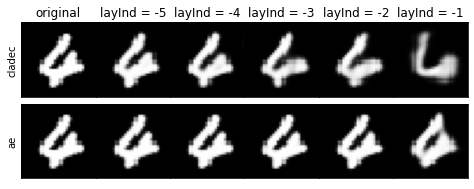

In [21]:
flag = False
from tqdm import tqdm
i=0
num_correct = 0
num_incorrect = 0
for j in tqdm(range(len(batch_ordered))):
    if flag:
        break
    for k in range(len(batch_ordered[j][0])):
        orig = batch_ordered[j][0][k].squeeze().numpy().astype(float)
        label = batch_ordered[j][1][k].item()
        pred = clf_preds[j][k].item()
        i = i+1
        if (label != pred and num_incorrect < 200) or (label == pred and num_correct < 200):
            ae_imgs = {t : reconstr_ae[t][j][0][k].squeeze().numpy().astype(float) for t in reconstr_ae.keys()}
            cladec_imgs = {t : reconstr_cladec[t][j][0][k].squeeze().numpy().astype(float) for t in reconstr_cladec.keys()}
            plt.rcParams["figure.figsize"] = (8,3)
            ax = plt.subplot(2,6,1)
            plotter(ax, orig, title="original", ylabel="cladec")
            ax = plt.subplot(2,6,7)
            plotter(ax, orig, ylabel="ae")
            for t in ae_imgs.keys():
                ax = plt.subplot(2,6,7 - t)
                plotter(ax, cladec_imgs[t], title="layInd = -" + str(t))
                ax = plt.subplot(2,6,13 - t)
                plotter(ax, ae_imgs[t])
            plt.subplots_adjust(hspace=0, wspace=0)

            if label == pred:
                img_name = "img_" + str(i) + "_label_" + str(label)+ ".jpg"
                path = os.path.join(correct_path, img_name)
                num_correct += 1
            else:
                img_name = "img_" + str(i) + "_label_" + str(label) + "_pred_" + str(pred) + ".jpg"
                path = os.path.join(incorrect_path, img_name)
                num_incorrect += 1
            plt.savefig(path)


In [22]:
import os

In [68]:
img1 = ae_reconstr[0][0][0].numpy().reshape(32,32).astype(float)
img2 = ae_reconstr[1][0][0].numpy().reshape(32,32).astype(float)
img3 = ae_reconstr[2][0][0].numpy().reshape(32,32).astype(float)

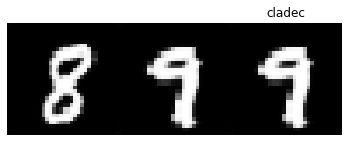

In [80]:
import matplotlib.pyplot as plt
plt.subplot(1,3,1)
plt.axis("off")
plt.imshow(img1, cmap="gray", label="cladec")
plt.subplot(1,3,2)
plt.axis("off")
plt.imshow(img2, cmap = "gray", label="bla")
plt.subplot(1,3,3)
plt.axis("off")
plt.imshow(img2, cmap="gray")
plt.title("cladec")
plt.subplots_adjust(wspace=0, hspace=0)



In [41]:
with tca.autocast():
    pred = classifier(batch.cuda())

In [33]:
pred.argmax(dim=1)

tensor([9, 1, 0, 8, 6, 3, 7, 1, 9, 5, 1, 8, 6, 3, 9, 7, 8, 7, 7, 3, 7, 1, 5, 7,
        4, 0, 8, 3, 5, 5, 0, 8, 6, 0, 3, 5, 9, 2, 2, 7, 1, 1, 1, 5, 0, 1, 2, 6,
        9, 9, 2, 7, 7, 0, 2, 4, 4, 4, 6, 2, 3, 3, 0, 5, 1, 1, 4, 4, 4, 5, 2, 5,
        6, 6, 3, 5, 0, 1, 9, 7, 2, 8, 0, 9, 6, 7, 3, 2, 1, 5, 3, 7, 6, 5, 2, 9,
        7, 7, 5, 8, 6, 6, 0, 6, 4, 3, 9, 4, 5, 1, 8, 9, 2, 3, 2, 4, 4, 2, 8, 8,
        9, 8, 0, 9, 3, 4, 1, 5], device='cuda:0')

In [37]:
label == pred.argmax(dim=1).detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])

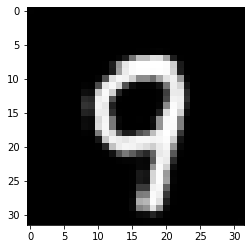

In [17]:
# Ref AE
plt.imshow(reconstr_ae[0][0].reshape(32,32).astype(float), cmap="gray")

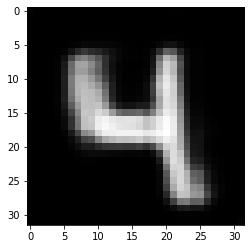

In [195]:
#Cladec
plt.imshow(reconstr_cladec[0][0].reshape(32,32).astype(float), cmap="gray")

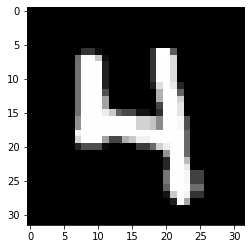

In [194]:
#Original
plt.imshow(batch[0].numpy().reshape(32,32).astype(float), cmap="gray")

In [97]:
%%time
cfg["layInd"] = -5
#get Activations
actModel = cladec.getActModel(cfg, classifier)
actModel.eval()
trds=getActs(train_dataset,actModel,cfg)


CPU times: user 1.18 s, sys: 810 ms, total: 1.99 s
Wall time: 1.72 s


In [98]:
%%time
#get RefAE
refAE,rcfg =cladec.getRefAE(cfg,trds) #Does not use activations themselves, only needs shape


Train RefAE
0 [0.11365]
2 [0.11546]
4 [0.00381]
6 [0.00241]
8 [0.0017]
10 [0.00159]
20 [0.00103]
30 [0.00059]
40 [0.00057]
50 [0.00052]
60 [0.00048]
CPU times: user 4min 36s, sys: 27.5 s, total: 5min 4s
Wall time: 5min 7s


In [99]:
%%time
# Train ClaDec
cladecNet,ccfg=  cladec.getClaDec(cfg,classifier,norm,trds)
print("ClaDec Final loss", ccfg)



Train CLaDec
0 [0.10969 0.10842 1.37545]
2 [0.10999 0.10883 1.27202]
4 [0.00766 0.00766 0.00747]
6 [0.00541 0.0054  0.01849]
8 [0.00486 0.00487 0.00059]
10 [0.00445 0.00446 0.00099]
20 [0.00373 0.00373 0.00067]
30 [0.00345 0.00346 0.0008 ]
40 [0.00337 0.00337 0.00059]
50 [0.00337 0.00337 0.00065]
60 [0.00331 0.00332 0.00047]
ClaDec Final loss {'ClaLo': 0.0033191756496695644}
CPU times: user 7min 8s, sys: 29.2 s, total: 7min 37s
Wall time: 7min 41s


In [100]:
#Explain
teds = getActs(val_dataset,actModel,cfg)
allimgs=[]
for i, data in enumerate(teds):
    with tca.autocast():
        dsx, dsy,dsact = data[0].cuda(), data[1].cuda(), data[2].cuda()
        outCla = cladecNet(dsact)
        outAE = refAE(dsx)
        for j in range(data[0].shape[0]):
            allimgs.append(data[0][j].numpy())
            allimgs.append(outAE[j].detach().cpu().numpy())
            allimgs.append(outCla[j].detach().cpu().numpy())
            if len(allimgs)==16*12: break
        if len(allimgs) == 16 * 12: break


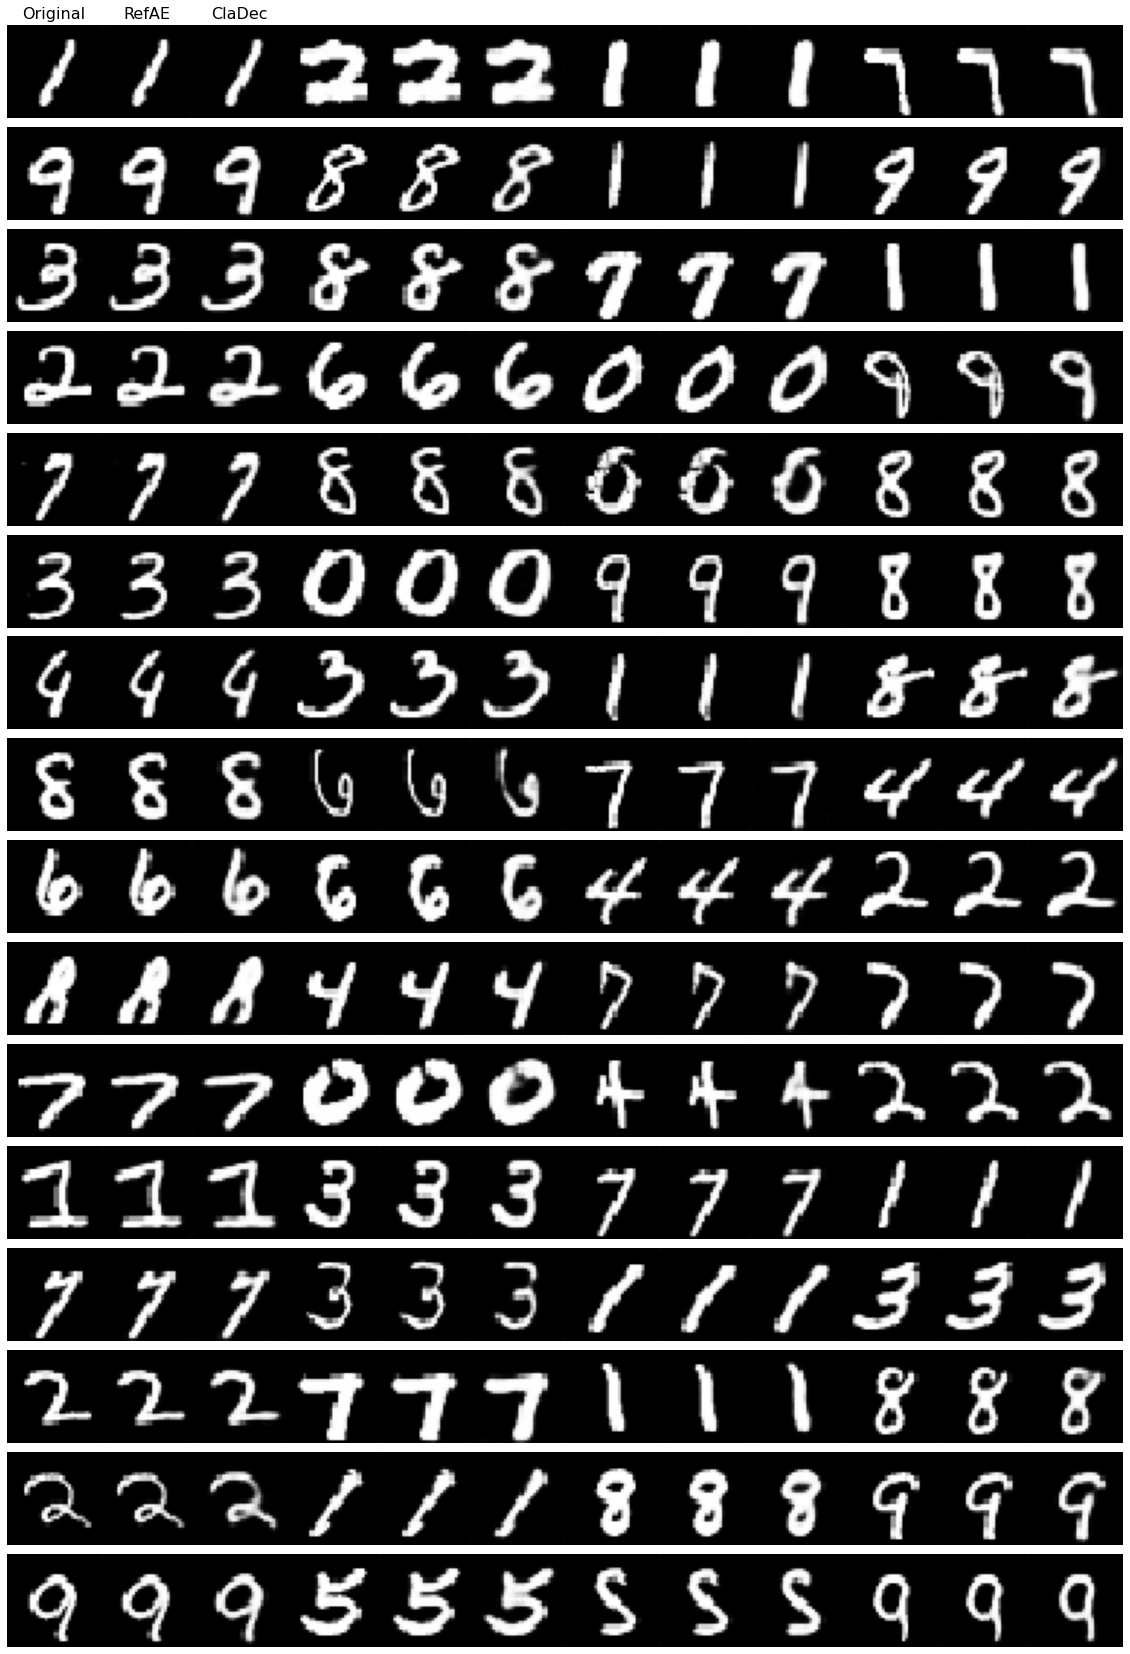

In [114]:
showPics(np.array(allimgs),fname=foldname+"Vis_Orig_AndClaDec",tits=["Original","RefAE","ClaDec"])


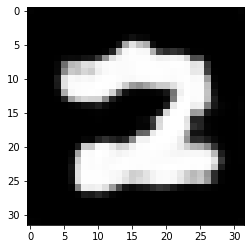

In [107]:
plt.imshow(allimgs[5].reshape(32,32).astype(float), cmap="gray")

In [102]:
import pickle
torch.save(refAE,"trained_models/MNIST/refAE_5.pt")
torch.save(cladecNet,"trained_models/MNIST/cladecNet_5.pt")
with open("trained_models/MNIST/img_dat_5.pickle","wb") as f:
    pickle.dump(allimgs, f)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [10]:
import argparse
import os
import numpy as np
import torchvision
import torchvision.transforms as transforms



train_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.MNIST(root = "./data", train=True, download=True, transform=train_transform)
#print(vars(train_set))
print(list(train_set.train_data.size()))
print(train_set.train_data.float().mean()/255)
print(train_set.train_data.float().std()/255)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Processing...
Done!


In [11]:
print(list(train_set.train_data.size()))


[60000, 28, 28]
/home/harshv834/my-envs/ml_def/lib/python3.8/site-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [13]:
from tiny_imagenet import TinyImageNetDataset
train_set = TinyImageNetDataset(train=True, download=True, transform=train_transform)


TypeError: __init__() got an unexpected keyword argument 'train'

In [20]:
data = next(iter(trds))

In [23]:
data[0].shape

torch.Size([128, 1, 28, 28])

In [12]:
torch.save(classifier,"trained_models/MNIST/clf.pt")